In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch


In [2]:
def getBorderColor(img):
    
    border = np.asarray(img[0,:])
    border = np.concatenate((border, np.asarray(img[-1, :])))
    border = np.concatenate((border, np.asarray(img[:, 0])))
    border = np.concatenate((border, np.asarray(img[:, -1])))
    return np.bincount(border).argmax()


def pre_processing(img):
    _, img_binarized = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    if(getBorderColor(img_binarized) != 0):
        img_binarized = cv2.bitwise_not(img_binarized) 
    return img_binarized



def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.show()    



def getFeaturesHOG(img):
   img = cv2.resize(img, (256, 128))
   cell_size = (32, 32)  # h x w in pixels
   block_size = (2, 2)  # h x w in cells
   nbins = 9  # number of orientation bins
   # winSize is the size of the image cropped to an multiple of the cell size
   hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

   hog_feats = hog.compute(img)
   return hog_feats.flatten()     

# Read Data, Split Training, Validation, Test

In [3]:
data_set = []
Y = []
for i in range(1, 10):
    for filename in os.listdir("ACdata_base/" + str(i)):
        img = cv2.imread(os.path.join("ACdata_base/" + str(i),filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data_set.append(pre_processing(img))
            Y.append(i)
            
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.4, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_testValid, Y_testValid, test_size=0.5, random_state=42)            

In [4]:
def getFeatures(images):
   x_features = []
   for i in range(len(images)):
        x_features.append(getFeaturesHOG(images[i]))
   return np.asarray(x_features)

In [5]:
train_features = getFeatures(X_train)
validation_features = getFeatures(X_validation)
test_features = getFeatures(X_test)


print(train_features.shape)
print(len(Y_train))

print(validation_features.shape)
print(len(Y_validation))

print(test_features.shape)
print(len(Y_test))


(1011, 756)
1011
(337, 756)
337
(337, 756)
337


In [6]:
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = train_features.shape[0], train_features.shape[1], 512, 9


# Create random Tensors to hold inputs and outputs
x = torch.tensor(train_features)
y = torch.tensor(Y_train)
y = y-1 #output layer nodes indices [0:8] not [1:9]

x_validation = torch.tensor(validation_features)
Y_validation = torch.tensor(Y_validation)
Y_validation = Y_validation - 1

x_test = torch.tensor(test_features)
y_test = torch.tensor(Y_test)
y_test = y_test - 1

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax(dim=1)
)

loss_fn = torch.nn.NLLLoss()

learning_rate = 1e-4


model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
validation_losses = []

In [11]:
for t in range(1000):

    x = x.to(device)
    y = y.to(device)
    
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item(),"  [Training]")
        training_losses.append(loss.item())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 100 == 99:
        with torch.no_grad():
            x_valid = x_validation.to(device)
            y_valid = Y_validation.to(device)
            y_pred2 = model(x_valid)
            loss = loss_fn(y_pred2, y_valid)
            print(t, loss.item(),"  [Validation]" )
            validation_losses.append(loss.item())


99 0.788316011428833   [Training]
99 0.8408178687095642   [Validation]
199 0.49566081166267395   [Training]
199 0.5953730940818787   [Validation]
299 0.34526288509368896   [Training]
299 0.4780306816101074   [Validation]
399 0.2556755542755127   [Training]
399 0.4151846766471863   [Validation]
499 0.19488833844661713   [Training]
499 0.378095805644989   [Validation]
599 0.15034541487693787   [Training]
599 0.35524502396583557   [Validation]
699 0.11652354896068573   [Training]
699 0.34106674790382385   [Validation]
799 0.09076791256666183   [Training]
799 0.33274826407432556   [Validation]
899 0.07104741036891937   [Training]
899 0.3280278742313385   [Validation]
999 0.05607368052005768   [Training]
999 0.3262142837047577   [Validation]


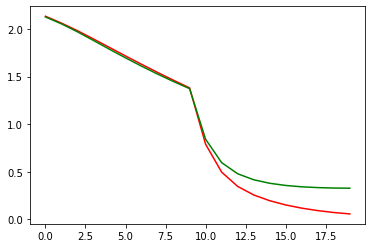

In [12]:
plt.plot(training_losses, '-r')
plt.plot(validation_losses, '-g')
plt.show()         

In [13]:
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y).item() / len(y)) * 100
    print("Training Accuracy = ", acc, "%")    

    x_valid = x_validation.to(device)
    y_valid = Y_validation.to(device)
    y_pred = model(x_valid)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_valid).item() / len(y_valid)) * 100
    print("Validation Accuracy = ", acc, "%")

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_test).item() / len(y_test)) * 100
    print("Test Accuracy = ", acc, "%")

Training Accuracy =  99.70326409495549 %
Validation Accuracy =  89.02077151335311 %
Test Accuracy =  91.0979228486647 %
